# Storm Indices

In [1]:
import storm_indices as si

import numpy as np
import pandas as pd
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import glob as gl
from datetime import datetime, date, time, timedelta
import calendar
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')

### Choose Station

In [2]:
station_name = 'ScottBase'

#station_name = 'MarblePoint'
#station_name = 'CapeBird'
#station_name = 'Margaret'
#station_name = 'Vito'
#station_name = 'Ferrell'
#station_name = 'Manuela'
#station_name = 'Alessandra'
#station_name = 'Silvia'

### Read in Temperature and Pressure Data

In [3]:
if station_name == 'ScottBase':
    # SCOTT BASE
    t_column_name = 'Mean Temperature [Deg C]'
    p_column_name = 'Mean sea level pressure [Hpa]'
    TP = pd.read_csv('../Data/scottbase/scottbase.csv')
    TP['DateTime'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
    TP.index = TP['DateTime']
    del TP['DateTime']
elif station_name in ['Vito', 'MarblePoint', 'Manuela', 'Ferrell', 'CapeBird', 'Margaret']:
    # AMRC AWS
    if station_name == 'Vito':
        TP = pd.read_csv('../Data/vito/vito.csv')
    elif station_name == 'MarblePoint':
        TP = pd.read_csv('../Data/marblePoint/marblePoint.csv')
    elif station_name == 'Manuela':
        TP = pd.read_csv('../Data/manuela/manuela.csv')
    elif station_name == 'Ferrell':
        TP = pd.read_csv('../Data/ferrell/ferrell.csv')
    elif station_name == 'CapeBird':
        TP = pd.read_csv('../Data/capebird/capebird.csv')
    elif station_name == 'Margaret':
        TP = pd.read_csv('../Data/margaret/margaret.csv')
    t_column_name = 'temperature'
    p_column_name = 'pressure'
    TP['DateTime'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
    TP.index = TP['DateTime']
    del TP['DateTime']
else:
    # WANG et al, 2022
    if station_name == 'Alessandra':
        TP = pd.read_csv('../Data/alessandra/alessandra.csv')
    elif station_name == 'Silvia':
        TP = pd.read_csv('../Data/silvia/silvia.csv')
    t_column_name = 'temperature_C'
    p_column_name = 'pressure_hPa'
    TP['DateTime'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
    TP.index = TP['DateTime']
    del TP['DateTime']

In [4]:
TP = TP[[t_column_name, p_column_name]]
TP = TP[~TP.index.isna()]

TP

,Mean Temperature [Deg C],Mean sea level pressure [Hpa]
DateTime,,
1964-09-30,NaN,1005.0
1964-10-01,-24.6,997.6
1964-10-02,-25.8,997.4
1964-10-03,-28.3,989.1
1964-10-04,-26.2,976.2
...,...,...
2025-05-10,-19.6,995.9
2025-05-11,-26.0,1001.5
2025-05-12,-28.8,1003.4


### Get Start and End Year

In [5]:
#start_year = int(np.min(TP.index.year))
start_year = 1964
#end_year = int(np.max(TP.index.year))
end_year = 2024
print(start_year, end_year)
years = np.array([int(i) for i in range(start_year, end_year+1)], dtype=int)
full_index = pd.date_range(start=str(start_year)+"-01-01", end=str(end_year)+"-12-31", freq="D")
TP = TP.reindex(full_index)

1964 2024


### Compute Storm Index

In [6]:
TP = si.compute_si(TP, t_column_name, p_column_name, 'SI')
TP

,Mean Temperature [Deg C],Mean sea level pressure [Hpa],SI
1964-01-01,NaN,NaN,NaN
1964-01-02,NaN,NaN,NaN
1964-01-03,NaN,NaN,NaN
1964-01-04,NaN,NaN,NaN
1964-01-05,NaN,NaN,NaN
...,...,...,...
2024-12-27,-3.4,989.1,0.0
2024-12-28,-4.7,993.9,0.0
2024-12-29,-2.9,989.5,0.0
2024-12-30,-1.2,985.8,0.0


### How many storms are stormier than average?

In [7]:
# Fraction of strong storm days in all storm days
fraction_of_strong_storms = (TP['SI'] > 1).sum() / (TP['SI'] > 0).sum()
# Fraction of strong storm days in all days
fraction_of_strong_storms_of_all_days = (TP['SI'] > 1).sum() / TP['SI'].notna().sum()
# How many of the strong storm days happen in winter?
TP_copy = TP.copy()
#TP_copy = TP.loc['1995-01-01':'2024-12-31'] # optionally limit to certain time ('1965-01-01':'1994-12-31' or '1995-01-01':'2024-12-31')
si_above_1 = TP_copy['SI'] > 1
days_with_si = TP_copy[si_above_1]
winter_months = [4, 5, 6, 7, 8, 9]
winter_days_with_si = days_with_si.index.month.isin(winter_months).sum()
total_days_with_si = si_above_1.sum()
winter_fraction_of_strong_storm_days = winter_days_with_si / total_days_with_si if total_days_with_si > 0 else float('nan')

print(fraction_of_strong_storms)
print(fraction_of_strong_storms_of_all_days)
print(winter_fraction_of_strong_storm_days)

0.2877948049125095
0.12052250694096764
0.7496223564954683


### How many storms that are stormier than average are there per year? And what is their average storminess?

In [8]:
TP_summer = TP[TP.index.month.isin([1, 2, 3, 10, 11, 12])]
TP_winter = TP[TP.index.month.isin([4, 5, 6, 7, 8, 9])]
count = (TP['SI'] > 1).groupby(TP.index.year).sum().to_frame(name='count')
count_summer = (TP_summer['SI'] > 1).groupby(TP_summer.index.year).sum().to_frame(name='count summer')
count_winter = (TP_winter['SI'] > 1).groupby(TP_winter.index.year).sum().to_frame(name='count winter')
mean = TP[TP['SI'] > 1].groupby(TP[TP['SI'] > 1].index.year)['SI'].mean().to_frame(name='mean')
mean_summer = TP_summer[TP_summer['SI'] > 1].groupby(TP_summer[TP_summer['SI'] > 1].index.year)['SI'].mean().to_frame(name='mean summer')
mean_winter = TP_winter[TP_winter['SI'] > 1].groupby(TP_winter[TP_winter['SI'] > 1].index.year)['SI'].mean().to_frame(name='mean winter')
strong_storms = pd.concat([count, count_summer, count_winter, mean, mean_summer, mean_winter], axis=1)
strong_storms

,count,count summer,count winter,mean,mean summer,mean winter
1964,5,5,0,1.099610,1.099610,NaN
1965,29,15,14,2.065209,2.611931,1.479435
1966,46,16,30,2.422538,1.830211,2.738445
1967,49,4,45,3.341474,1.258557,3.526622
1968,29,4,25,3.077722,1.577988,3.317680
...,...,...,...,...,...,...
2020,58,17,41,2.889693,2.024204,3.248554
2021,29,0,29,2.898027,NaN,2.898027
2022,93,28,65,3.059077,1.968496,3.528865
2023,41,17,24,2.351995,1.584330,2.895758


### Compute Annual and Seasonal Sums of Storm Index

In [9]:
min_days = 183
min_days_winter = 92

TP['year'] = TP.index.year
TP_winter = TP.copy()
TP_winter['month'] = TP_winter.index.month
TP_winter['winter'] = np.where(TP_winter['month'].isin([4, 5, 6, 7, 8, 9]), True, False)
TP_winter = TP_winter[TP_winter['winter'] == True]
TP_summer = TP.copy()
TP_summer['month'] = TP_summer.index.month
TP_summer['summer'] = np.where(TP_summer['month'].isin([1, 2, 3, 10, 11, 12]), True, False)
TP_summer = TP_summer[TP_summer['summer'] == True]

# sum up and divide by the count of non-nan-values per year/winter for an annual/seasonal storm index with a per-day unit
number_of_non_nan_days = TP.groupby(['year'])['SI'].count()
annual = TP.groupby(['year'])['SI'].sum() / number_of_non_nan_days
number_of_non_nan_days_winter = TP_winter.groupby(['year'])['SI'].count()
seasonal = TP_winter.groupby(['year'])['SI'].sum() / number_of_non_nan_days_winter
number_of_non_nan_days_summer = TP_summer.groupby(['year'])['SI'].count()
seasonal_summer = TP_summer.groupby(['year'])['SI'].sum() / number_of_non_nan_days_summer

del TP['year']

# handle data gaps
full_years = pd.Index(range(start_year, end_year + 1), name='year')
annual = annual.reindex(full_years)
seasonal = seasonal.reindex(full_years)
seasonal_summer = seasonal_summer.reindex(full_years)
invalid_years = number_of_non_nan_days[number_of_non_nan_days < min_days].index
invalid_years_winter = number_of_non_nan_days_winter[number_of_non_nan_days_winter < min_days_winter].index
invalid_years_summer = number_of_non_nan_days_summer[number_of_non_nan_days_summer < min_days_winter].index
annual.loc[invalid_years] = np.nan
seasonal.loc[invalid_years_winter] = np.nan
seasonal_summer.loc[invalid_years_summer] = np.nan

In [10]:
ASI = pd.DataFrame({'all':annual.values, 'winter':seasonal.values, 'summer':seasonal_summer.values}, index=full_years)
ASI

,all,winter,summer
year,,,
1964,NaN,NaN,0.108002
1965,0.240765,0.195925,0.285852
1966,0.402417,0.580027,0.222844
1967,0.520706,0.933815,0.105327
1968,0.296826,0.506366,0.087286
...,...,...,...
2020,0.574703,0.860964,0.288442
2021,0.318855,0.548679,0.087769
2022,0.850187,1.316622,0.381189


### Prepare Second Dataframe with years split into columns (helpful for plotting)

In [11]:
df = TP.copy()

df['month_day'] = df.index.strftime('%m-%d')
df['year'] = df.index.year

# Create a new DataFrame with desired structure
TP_plot = pd.concat([
    df.pivot(index='month_day', columns='year', values=t_column_name).add_prefix('T'),
    df.pivot(index='month_day', columns='year', values=p_column_name).add_prefix('P'),
    df.pivot(index='month_day', columns='year', values='SI').add_prefix('SI')
], axis=1)

TP_plot

year,T1964,T1965,T1966,T1967,T1968,T1969,T1970,T1971,T1972,T1973,...,SI2015,SI2016,SI2017,SI2018,SI2019,SI2020,SI2021,SI2022,SI2023,SI2024
month_day,,,,,,,,,,,,,,,,,,,,,
01-01,NaN,-4.5,-1.8,-2.0,-1.3,-1.7,-1.1,0.4,-2.0,-4.3,...,0.058942,1.572846,0.202557,0.187995,0.026976,0.000000,0.867206,0.078900,0.526285,0.321915
01-02,NaN,-4.4,-2.4,-2.3,-3.2,-6.2,-2.1,1.3,-2.7,-6.3,...,0.000000,1.293234,0.202557,0.120574,0.098595,0.000000,0.563981,0.010894,0.518374,0.446292
01-03,NaN,-2.0,-3.7,-3.6,-4.6,-6.4,-4.2,1.5,-1.4,-8.1,...,0.000000,0.471517,0.199429,0.000000,0.098595,0.000000,0.282219,0.000000,0.381145,0.580930
01-04,NaN,-7.3,-4.2,0.2,-2.7,-6.1,-4.0,1.4,-1.6,-9.6,...,0.000000,0.358038,0.000000,0.000000,0.071619,0.000000,0.000000,0.000000,0.373136,0.424527
01-05,NaN,-3.8,-3.9,1.3,-2.7,-7.7,-2.0,-0.5,-6.5,-10.6,...,0.000000,0.444297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353892,0.224887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-27,-3.9,-2.4,-2.8,-3.0,-2.0,-2.9,-6.0,-3.7,-3.3,-3.9,...,0.296071,0.000000,0.275082,0.080898,0.000000,0.486663,0.450087,0.497186,1.552586,0.000000
12-28,-0.5,-3.6,-5.0,-8.1,-0.5,-1.3,-8.3,-6.5,-4.9,-2.6,...,0.484616,0.021330,0.361296,0.481788,0.000000,1.264251,0.619249,0.869865,0.981266,0.000000
12-29,-0.3,-0.7,-5.4,-3.6,-2.0,-0.4,-4.8,-4.5,-6.0,-2.6,...,0.372605,0.021330,0.365304,0.488394,0.000000,2.035948,0.694387,1.467950,0.320674,0.000000


### Compute Center of Storminess and Width of Storminess Distribution per Year

In [12]:
invalid_years = {}

In [13]:
CoS = []                              # DoY of Center of Storminess per year.
a = np.arange(len(TP_plot))
for i in years:
    weights = TP_plot['SI'+str(i)]
    masked_weights = np.ma.MaskedArray(weights, mask=np.isnan(weights))
    if masked_weights.count() < 335:
        CoS.append(np.nan)
        invalid_years[i] = True
    else:
        center = np.ma.average(a, weights=masked_weights)
        CoS.append(center)
        invalid_years[i] = False
CoS_df = pd.DataFrame({'years': years, 'cos': CoS})
CoS_df[50:]

,years,cos
50,2014,206.335545
51,2015,202.992777
52,2016,153.103284
53,2017,187.905184
54,2018,180.319563
55,2019,189.268399
56,2020,205.435536
57,2021,163.510463
58,2022,192.294210
59,2023,209.212802


In [14]:
CoS_df.index = CoS_df['years']
m, b, p_m, p_b = si.linear_fit(CoS_df, 'cos')
print(m, b, p_m, p_b)
print(f"Shift of center of storminess in days per year: {m}")

-0.15429053219587252 491.5873263790569 0.3640194290509027 0.1493183670730227
Shift of center of storminess in days per year: -0.15429053219587252


# Plot

In [15]:
# format x-axis
month_starts = [f'{m}-01' for m in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']]
month_start_positions = [TP_plot.index.get_loc(month_start) for month_start in month_starts]
month_start_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# colormap for years, corresponding to sum of the storm index of each year
cmap = cm.get_cmap('viridis') #'rainbow'
colors = cmap(ASI['all']/ASI['all'].max())
norm = plt.Normalize(0, ASI['all'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

### Strong Storms Summer-Winter

In [16]:
m0, b0, p_m0, p_b0 = si.linear_fit(strong_storms, 'count')
m1, b1, p_m1, p_b1 = si.linear_fit(strong_storms, 'count winter')
m2, b2, p_m2, p_b2 = si.linear_fit(strong_storms, 'count summer')
m3, b3, p_m3, p_b3 = si.linear_fit(strong_storms, 'mean')
m4, b4, p_m4, p_b4 = si.linear_fit(strong_storms, 'mean winter')
m5, b5, p_m5, p_b5 = si.linear_fit(strong_storms, 'mean summer')

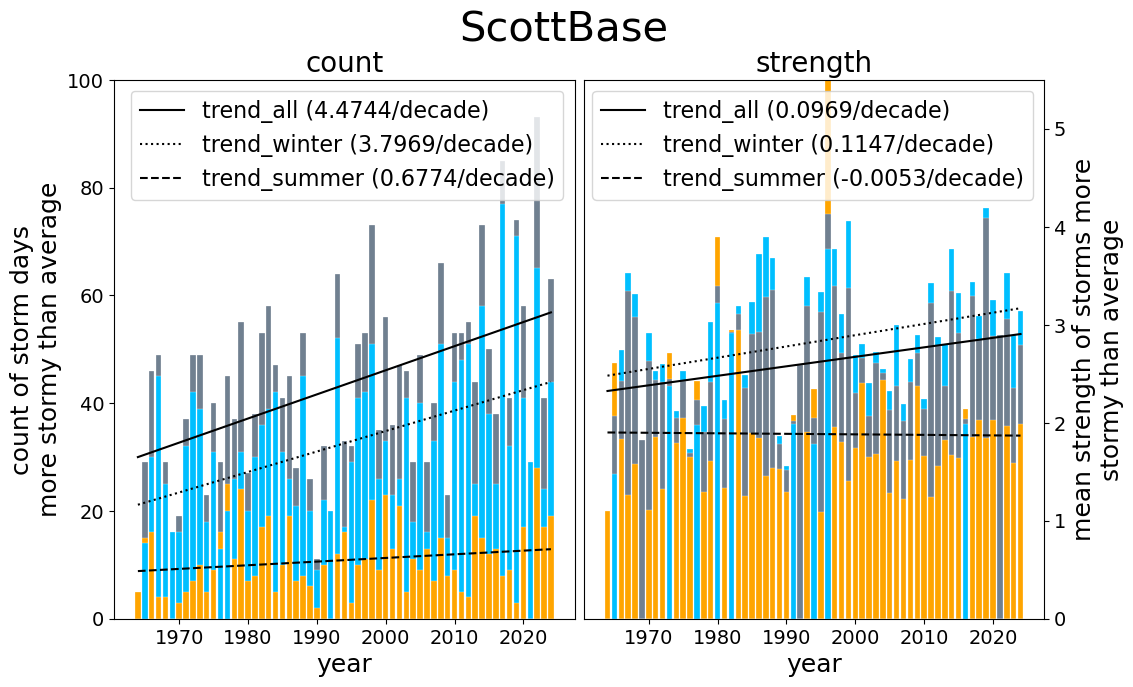

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,7), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1, 1]})
plt.subplots_adjust(wspace=0.02)
fig.suptitle(station_name, fontsize=30)

ax[0].plot(strong_storms.index, m0*strong_storms.index+b0, color='black', linestyle='-', label=f'trend_all ({round(float(10*m0), 4)}/decade)')
ax[0].plot(strong_storms.index, m1*strong_storms.index+b1, color='black', linestyle=':', label=f'trend_winter ({round(float(10*m1), 4)}/decade)')
ax[0].plot(strong_storms.index, m2*strong_storms.index+b2, color='black', linestyle='--', label=f'trend_summer ({round(float(10*m2), 4)}/decade)')
ax[0].bar(strong_storms.index, strong_storms['count'], color='slategrey', edgecolor='white', linewidth=0.2)
ax[0].bar(strong_storms.index, strong_storms['count winter'], color='deepskyblue', edgecolor='white', linewidth=0.2)
ax[0].bar(strong_storms.index, strong_storms['count summer'], color='orange', edgecolor='white', linewidth=0.2)
ax[0].bar(strong_storms.index, np.where((strong_storms['count winter'] < strong_storms['count summer']), strong_storms['count winter'], 0), color='deepskyblue', edgecolor='white', linewidth=0.2)
ax[0].legend(fontsize=16, ncol=1)
ax[0].set_title('count', fontsize=20)
ax[0].tick_params(labelsize=14)
ax[0].set_ylim((0,100))
ax[0].set_xlabel('year', fontsize=18)
ax[0].set_ylabel('count of storm days\nmore stormy than average', fontsize=18)

ax[1].plot(strong_storms.index, m3*strong_storms.index+b3, color='black', linestyle='-', label=f'trend_all ({round(float(10*m3), 4)}/decade)')
ax[1].plot(strong_storms.index, m4*strong_storms.index+b4, color='black', linestyle=':', label=f'trend_winter ({round(float(10*m4), 4)}/decade)')
ax[1].plot(strong_storms.index, m5*strong_storms.index+b5, color='black', linestyle='--', label=f'trend_summer ({round(float(10*m5), 4)}/decade)')
ax[1].bar(strong_storms.index, strong_storms['mean winter'], color='deepskyblue', edgecolor='white', linewidth=0.2)
ax[1].bar(strong_storms.index, strong_storms['mean'], color='slategrey', edgecolor='white', linewidth=0.2)
ax[1].bar(strong_storms.index, strong_storms['mean summer'], color='orange', edgecolor='white', linewidth=0.2)
ax[1].bar(strong_storms.index, np.where((strong_storms['mean'] < strong_storms['mean summer']), strong_storms['mean'], 0), color='slategrey', edgecolor='white', linewidth=0.2)
ax[1].bar(strong_storms.index, np.where((strong_storms['mean winter'] < strong_storms['mean']), strong_storms['mean winter'], 0), color='deepskyblue', edgecolor='white', linewidth=0.2)
ax[1].legend(fontsize=16, ncol=1)
ax[1].set_title('strength', fontsize=20)
ax[1].tick_params(labelsize=14)
ax[1].set_ylim((0,5.5))
ax[1].set_xlabel('year', fontsize=18)
ax[1].set_ylabel('mean strength of storms more\nstormy than average', fontsize=18)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

plt.savefig('../Figures/'+str(station_name)+'_strong_storms_winter_summer', bbox_inches='tight')
plt.show()

### Annual Storm Index

In [18]:
m0, b0, p_m0, p_b0 = si.linear_fit(ASI, 'all')
m1, b1, p_m1, p_b1 = si.linear_fit(ASI, 'winter')
m2, b2, p_m2, p_b2 = si.linear_fit(ASI, 'summer')

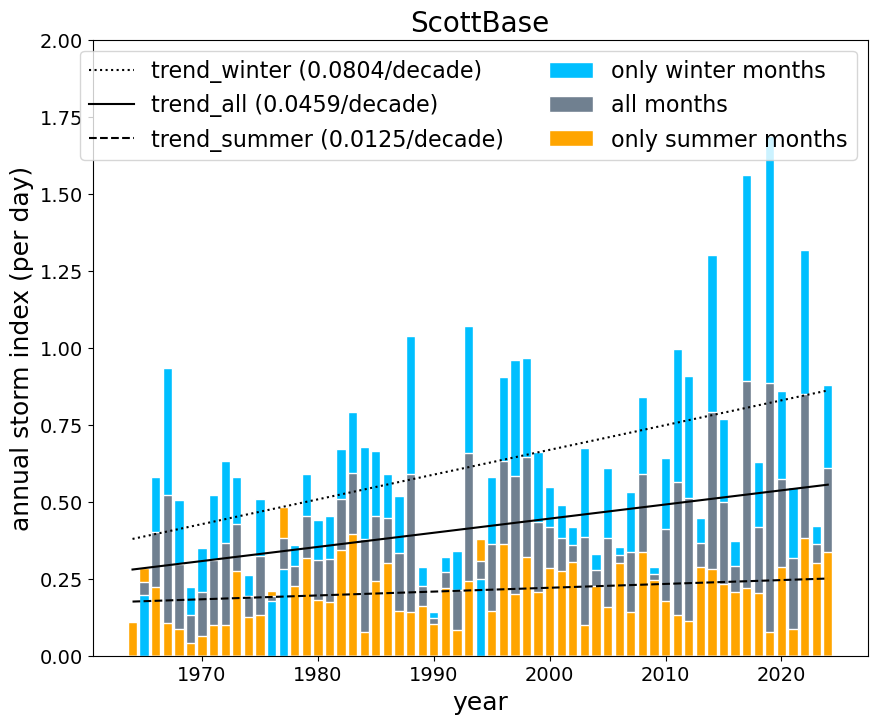

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.plot(ASI.index, m1*ASI.index+b1, color='black', linestyle=':', label=f'trend_winter ({round(float(10*m1), 4)}/decade)')
ax.plot(ASI.index, m0*ASI.index+b0, color='black', linestyle='-', label=f'trend_all ({round(float(10*m0), 4)}/decade)')
ax.plot(ASI.index, m2*ASI.index+b2, color='black', linestyle='--', label=f'trend_summer ({round(float(10*m2), 4)}/decade)')
ax.bar(ASI.index, ASI['winter'], color='deepskyblue', edgecolor='white', label='only winter months')
ax.bar(ASI.index, ASI['all'], color='slategray', edgecolor='white', label='all months')
ax.bar(ASI.index, ASI['summer'], color='orange', edgecolor='white', label='only summer months')
ax.bar(ASI.index, np.where((ASI['all'] < ASI['summer']), ASI['all'], 0), color='slategray', edgecolor='white')
ax.bar(ASI.index, np.where((ASI['winter'] < ASI['all']), ASI['winter'], 0), color='deepskyblue', edgecolor='white')
ax.legend(fontsize=16, ncol=2)
ax.set_title(station_name, fontsize=20)
ax.tick_params(labelsize=14)
ax.set_ylim((0,2))
ax.set_xlabel('year', fontsize=18)
ax.set_ylabel('annual storm index (per day)', fontsize=18)

plt.savefig('../Figures/'+str(station_name)+'_asi_summer', bbox_inches='tight')
plt.show()

### Inter-annual variability

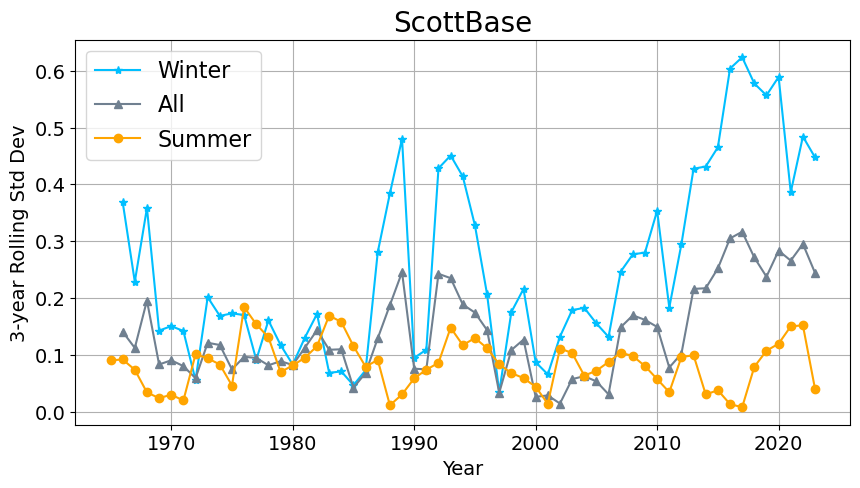

In [20]:
window=3
ASI_std = ASI.rolling(window=window, center=True).std()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ASI_std.index, ASI_std['winter'], marker='*', linestyle='-', label='Winter', color='deepskyblue')
ax.plot(ASI_std.index, ASI_std['all'], marker='^', linestyle='-', label='All', color='slategray')
ax.plot(ASI_std.index, ASI_std['summer'], marker='o', linestyle='-', label='Summer', color='orange')

ax.set_ylabel(str(window)+'-year Rolling Std Dev', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(fontsize=16, ncol=1)
ax.set_title(station_name, fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(True)

plt.savefig('../Figures/'+str(station_name)+'_'+str(window)+'year_std', bbox_inches='tight')
plt.show()